# How to save and restart a WorkTree

## Introduction
`WorkTree` supports save and load a WorkTree and modify the workflow, then submit the job again. WorkTree save its data as a extra attribute into its process, so that one can rebuild the WorkTree from the process.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='10014391ebf5492db57a6edfea62c68e' name='default'>

## Create a WorkTree

In [2]:
from aiida_worktree import node
from aiida.engine import calcfunction

# define add node
@node()
@calcfunction
def add(x, y):
    return x + y

from aiida_worktree import WorkTree
from aiida.orm import Int
x = Int(2.0)
y = Int(3.0)
z = Int(4.0)

wt = WorkTree("first_workflow")
wt.nodes.new(add, name="add1", x=x, y=y)
wt.nodes.new(add, name="add2", x=x, y=y)
wt.nodes.new(add, name="add3", x=x, y=y)
wt.links.new(wt.nodes["add1"].outputs[0], wt.nodes["add2"].inputs["x"])
wt.links.new(wt.nodes["add2"].outputs[0], wt.nodes["add3"].inputs["x"])

# save the worktree
wt.save(submit=False)
# wt.submit()


Check the state and pk of the worktree:

In [7]:
!verdi process list


  PK  Created    Process label    ♻    Process State    Process status
----  ---------  ---------------  ---  ---------------  ----------------
3029  26s ago    WorkTree              ⏹ Created
3032  21s ago    WorkTree              ⏹ Created
3035  16s ago    WorkTree              ⏹ Created
3038  13s ago    WorkTree              ⏹ Created
3041  3s ago     WorkTree              ⏹ Created

Total results: 5

Report: ♻ Processes marked with check-mark were not run but taken from the cache.
Report: Add the option `-P pk cached_from` to the command to display cache source.
Report: Last time an entry changed state: 3s ago (at 13:10:28 on 2023-12-04)
Report: Checking daemon load... OK
Report: Using 2% of the available daemon worker slots.


## Load the WorkTree and submit
Now, we want to add a new `add` node, and use the results from previous `add1` and `multiply1` nodes. Use the `load` method to load a WorkTree from a process.

In [8]:
from aiida_worktree import WorkTree
pk = wt.pk
wt2 = WorkTree.load(pk)
wt2.nodes["add2"].set({"y": Int(4).store()})
wt2.submit(wait=True)

12/04/2023 01:10:34 PM <233126> aiida.process_control: [REPORT] request to play Process<3041> sent


### Check status and results


In [5]:
print("State of WorkTree   : {}".format(wt2.state))
print('Result of add1      : {}'.format(wt2.nodes["add1"].node.outputs.result.value))
print('Result of add2      : {}'.format(wt2.nodes["add2"].node.outputs.result.value))

State of WorkTree   : FINISHED
Result of add1      : 5
Result of add2      : 9


Generate node graph from the AiiDA process:

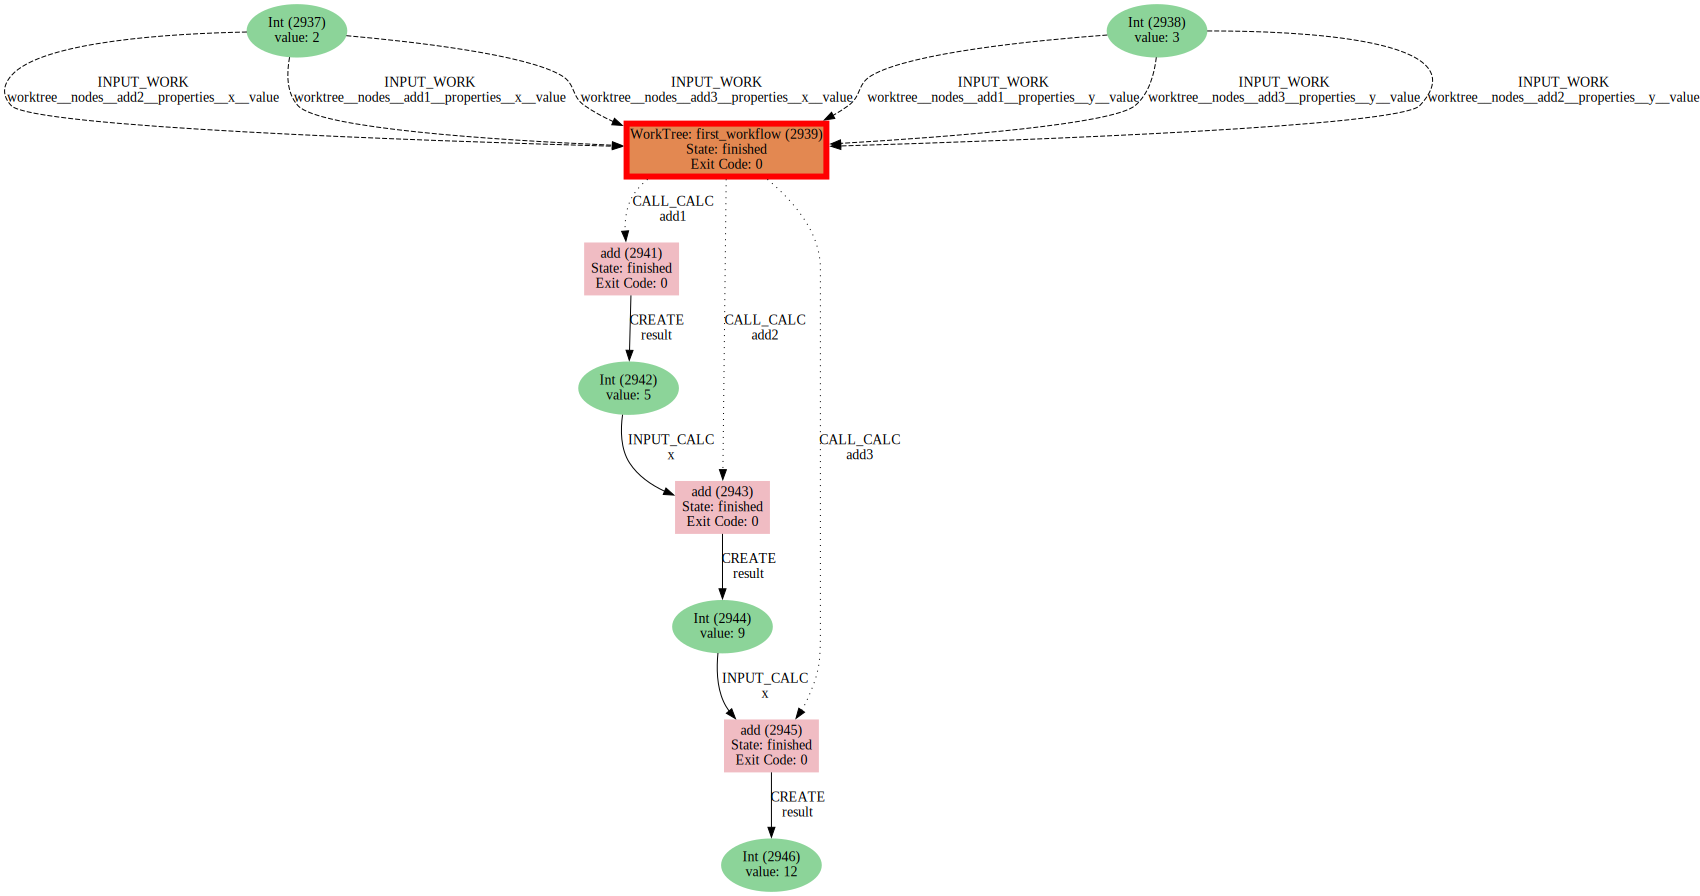

In [6]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt2.pk)